# Tom Almog — AI Skill Showcase (DINO + KMeans Segmentation)

This notebook demonstrates unsupervised image segmentation with DINO ViT features + KMeans.

It:
- Loads two example images (swap with your own if you want)
- Extracts ViT features using pretrained DINO (torch.hub)
- Clusters patches (and optionally per-pixel) with KMeans
- Visualizes original vs overlayed segments side-by-side


In [52]:
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install -q numpy matplotlib scikit-learn pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
import io
import math
import urllib.request
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import torch
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


@dataclass
class ImageBatch:
    image_pil: Image.Image
    image_tensor: torch.Tensor  # [1,3,H,W], float32, 0..1
    original_size: Tuple[int, int]


def load_image_from_url(url: str, target_size: int = 384) -> ImageBatch:
    with urllib.request.urlopen(url) as resp:
        data = resp.read()
    pil = Image.open(io.BytesIO(data)).convert("RGB")
    w, h = pil.size
    scale = target_size / max(w, h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    pil_resized = pil.resize((new_w, new_h), Image.BICUBIC)
    arr = np.array(pil_resized).astype(np.float32) / 255.0
    tensor = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0)
    return ImageBatch(pil, tensor, (h, w))


def make_grid_show(images, titles, ncols=2, figsize=(10, 6)):
    n = len(images)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows == 1:
        axes = np.array([axes])
    for idx in range(nrows * ncols):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        ax.axis("off")
        if idx < n:
            ax.imshow(images[idx])
            ax.set_title(titles[idx])
    plt.tight_layout()
    return fig


In [54]:
# load pretrained DINO ViT
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
model.eval()

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def extract_vit_features(img_tensor: torch.Tensor):
    # pad to nearest multiple of patch size to keep a clean grid
    _, _, h, w = img_tensor.shape
    pad_h = (16 - (h % 16)) % 16
    pad_w = (16 - (w % 16)) % 16
    img_pad = torch.nn.functional.pad(img_tensor, (0, pad_w, 0, pad_h), mode='reflect')

    x = (img_pad - IMAGENET_MEAN) / IMAGENET_STD
    with torch.no_grad():
        # forward_features returns tokens
        feats = model.get_intermediate_layers(x, n=1)[0]  # [B, 1+N, C]
    # remove class token
    patch_feats = feats[:, 1:, :]  # [B, N, C]
    b, n, c = patch_feats.shape
    # infer grid dims
    grid_h = (h + pad_h) // 16
    grid_w = (w + pad_w) // 16
    patch_feats = patch_feats.reshape(b, grid_h, grid_w, c).squeeze(0)  # [H', W', C]
    return patch_feats, (grid_h, grid_w), (h, w)



Using cache found in /Users/tomalmog/.cache/torch/hub/facebookresearch_dino_main


In [55]:
def kmeans_segment(patch_features: torch.Tensor, grid_size, image_size, k: int = 4):
    h_p, w_p = grid_size
    h, w = image_size
    feats = patch_features.reshape(-1, patch_features.shape[-1]).cpu().numpy()
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(feats)  # [H'*W']
    labels_grid = labels.reshape(h_p, w_p)

    seg_small = Image.fromarray(labels_grid.astype(np.uint8))
    seg_big = seg_small.resize((w, h), Image.NEAREST)
    seg = np.array(seg_big)


    rng = np.random.default_rng(123)
    palette = rng.integers(low=50, high=255, size=(k, 3), dtype=np.uint8)
    seg_rgb = palette[seg]
    return seg, seg_rgb



## Two image demo of unsupervised segmentation
The next cells run a quick example of the original images vs the AI overlay, i set low k values so there are few regions but it runs fast


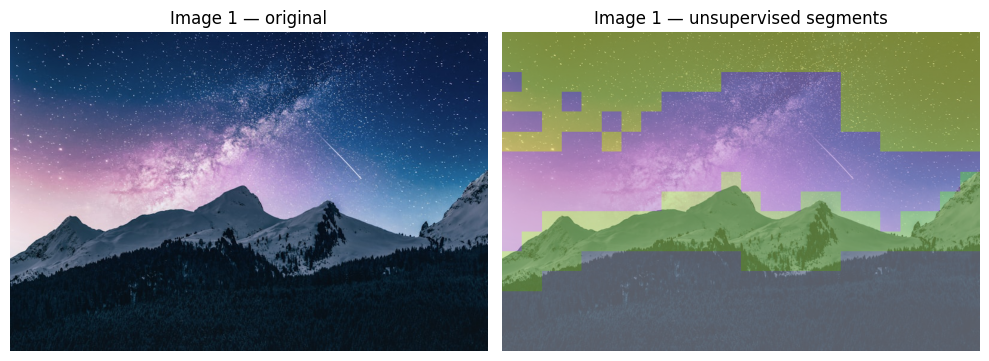

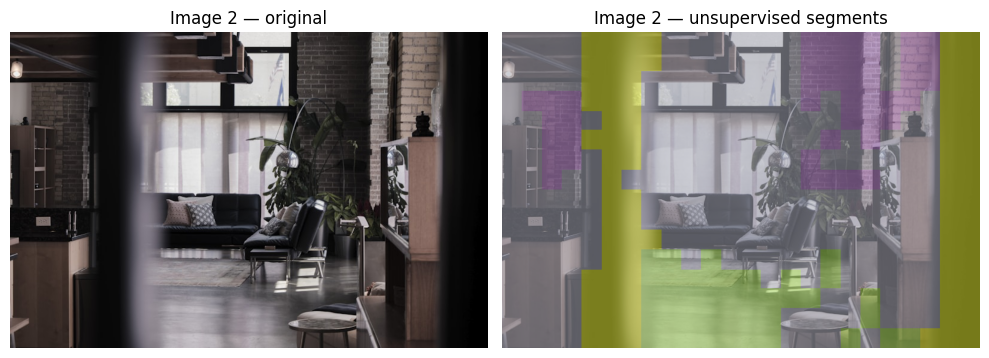

In [56]:
# demo with two images. you can replace the urls with your own to test it out
URL_1 = "https://images.unsplash.com/photo-1519681393784-d120267933ba?w=800"  # mountain
URL_2 = "https://images.unsplash.com/photo-1507149833265-60c372daea22?w=800"  # house

img1 = load_image_from_url(URL_1, target_size=384)
img2 = load_image_from_url(URL_2, target_size=384)

# Extract patch features
pf1, grid1, size1 = extract_vit_features(img1.image_tensor)
pf2, grid2, size2 = extract_vit_features(img2.image_tensor)

# Cluster patches
labels1, seg_rgb1 = kmeans_segment(pf1, grid1, size1, k=4)
labels2, seg_rgb2 = kmeans_segment(pf2, grid2, size2, k=4)

# Compose overlays (alpha blend with original)
def overlay(original_pil: Image.Image, seg_rgb: np.ndarray, alpha: float = 0.5) -> Image.Image:
    seg_pil = Image.fromarray(seg_rgb)
    seg_pil = seg_pil.resize(original_pil.size, Image.NEAREST)
    return Image.blend(original_pil.convert("RGB"), seg_pil.convert("RGB"), alpha)

over1 = overlay(img1.image_pil, seg_rgb1, alpha=0.5)
over2 = overlay(img2.image_pil, seg_rgb2, alpha=0.5)

# Visualize side-by-side per image
make_grid_show(
    [img1.image_pil, over1],
    ["Image 1 — original", "Image 1 — unsupervised segments"],
    ncols=2,
    figsize=(10, 5)
)
plt.show()

make_grid_show(
    [img2.image_pil, over2],
    ["Image 2 — original", "Image 2 — unsupervised segments"],
    ncols=2,
    figsize=(10, 5)
)
plt.show()


## Single image demo: custom image (before vs AI overlay)
Set `imageurl` in the next cell; the rest will reuse it automatically.


Using cache found in /Users/tomalmog/.cache/torch/hub/facebookresearch_dino_main


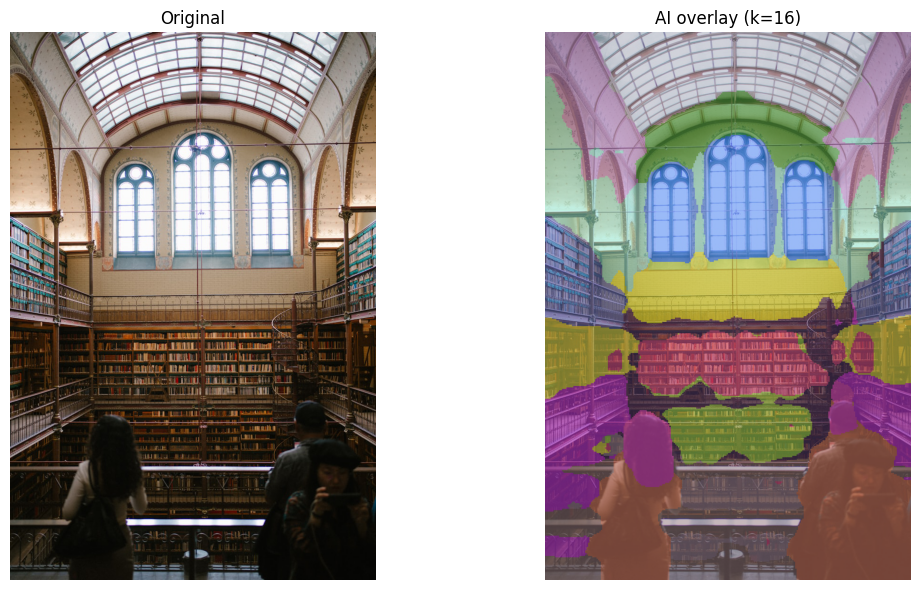

In [57]:
from dino_kmeans_segmentation import (
    load_image_from_url,
    load_dino_model,
    extract_vit_features,
    kmeans_segment,
    overlay,
)
import matplotlib.pyplot as plt

# try it out with yoru own image just put url here
imageurl = "https://images.unsplash.com/photo-1758380743428-ac0b72817e94?q=80&w=774&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

# this loads the model and whatever image was given
model = load_dino_model()
img = load_image_from_url(imageurl, target_size=384)

# extracs features from the image, set your own k value to choose how many segments
# i set the k value to 16, i find that putting it any higher makes it take too long
patch_feats, grid, size = extract_vit_features(model, img.image_tensor)
_, seg_rgb = kmeans_segment(patch_feats, grid, size, k=16, per_pixel=True)

# overlay and show side by side
before = img.image_pil
after = overlay(before, seg_rgb, alpha=0.5)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(before)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(after)
axes[1].set_title("AI overlay (k=16)")
axes[1].axis("off")
plt.tight_layout()
plt.show()
